# Статистика, DS-поток
## Задание SP.7

**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds23_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания получат штраф.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.


**Баллы за задание:**

* Задача 1 &mdash; 40 баллов;
* Задача 2 &mdash; 30 баллов;
* Задача 3 &mdash; 30 баллов;
* Задача 4 &mdash; 30 баллов;
* Задача 5 &mdash; 60 баллов.

**Важность задач:**

* *высокая:* задачи 1, 5;
* *средняя:* задача 3, 4;
* *обычная:* задача 2.

In [ ]:
# Bot check

# HW_ID: ds_sp7
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [67]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.3, palette='Set2')

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE, mean_absolute_percentage_error as MAPE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.nonparametric.kernel_regression import KernelReg
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.nonparametric.kde import KDEUnivariate

___
### Задача 1.

Для данных из задачи ML.5.2 рассмотрим две модели: случайный лес и ридж-регрессия. Постройте бутстрепные доверительные интервалы трех типов для метрик MSE, MAE, MAPE этих двух моделей.

**Решение:**

*На лекции было представлено 3 вида бутстрепных доверительных интервалов:*  
1. *Нормальный интервал, ni*   
$\left( \hat{\theta} - z_{\frac{1+\alpha}{2}} \sqrt{\hat{v}_{boot}} , \hat{\theta} + z_{\frac{1+\alpha}{2}} \sqrt{\hat{v}_{boot}} \right)$, где $\hat{v}_{boot}$ - бутстрепная оценка дисперсии, $\hat{\theta}$ - а.н.о. $\theta$ c а.д. $\sigma^2(\theta)$  
2. *Центральный интервал, ci*  
$\left( 2\hat{\theta} - \theta^{*}_{(\lceil B(1+\alpha)/2 \rceil)} , 2\hat{\theta} - \theta^{*}_{(\lfloor B(1-\alpha)/2 \rfloor)} \right)$, где $\hat{\theta}$ - оценка методом подстановки, $\theta^{*}_1,...,\theta^{*}_B$ - оценки по бутстрепным выборкам  
3. *Квантильный интервал, qi*  
$\left( \theta^{*}_{(\lfloor B(1-\alpha)/2 \rfloor)} , \theta^{*}_{(\lceil B(1+\alpha)/2 \rceil)} \right)$, где $\hat{\theta}$ - некоторая оценка $\theta$, $\theta^{*}_1,...,\theta^{*}_B$ - оценки по бутстрепным выборкам  

In [115]:
housing = fetch_california_housing()
X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target, test_size=0.25, random_state=42)

In [129]:
def ni(X, alpha=0.95):  # X - массив ошибок (квадраты, модули, относительные)
    """Нормальный интервал"""
    n, B = len(X), len(X)  # B=n
    theta_hat = np.mean(X)
    bootstrap_samples = np.take(np.stack([X]*B), sps.randint.rvs(0, n, size=(B,n)))
    Ts = np.var(bootstrap_samples, axis=1)  #assert len(Ts) == B
    v_boot = np.var(Ts)
    z = sps.norm.ppf((1+alpha)/2) # z=1.96 при alpha=0.95
    return theta_hat - z*np.sqrt(v_boot), theta_hat + z*np.sqrt(v_boot)

def ci(X, alpha=0.95):  # X - массив ошибок (квадраты, модули, относительные)
    """Центральный интервал"""
    n, B = len(X), len(X)  # B=n
    theta_hat = np.mean(X)
    bootstrap_samples = np.take(np.stack([X]*B), sps.randint.rvs(0, n, size=(B,n)))
    theta_stars = sorted(np.mean(bootstrap_samples, axis=1))  #assert len(theta_stars) == B
    return 2*theta_hat - theta_stars[int(np.ceil(B*(1+alpha)/2))], 2*theta_hat - theta_stars[int(np.floor(B*(1-alpha)/2))]

def qi(X, alpha=0.95):  # X - массив ошибок (квадраты, модули, относительные)
    """Квантильный интервал"""
    n, B = len(X), len(X)  # B=n
    bootstrap_samples = np.take(np.stack([X]*B), sps.randint.rvs(0, n, size=(B,n)))
    theta_stars = sorted(np.mean(bootstrap_samples, axis=1))  #assert len(theta_stars) == B
    return theta_stars[int(np.floor(B*(1-alpha)/2))], theta_stars[int(np.ceil(B*(1+alpha)/2))]  

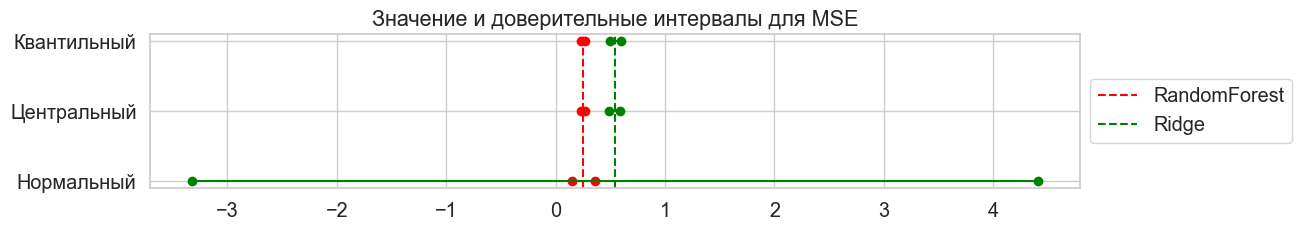

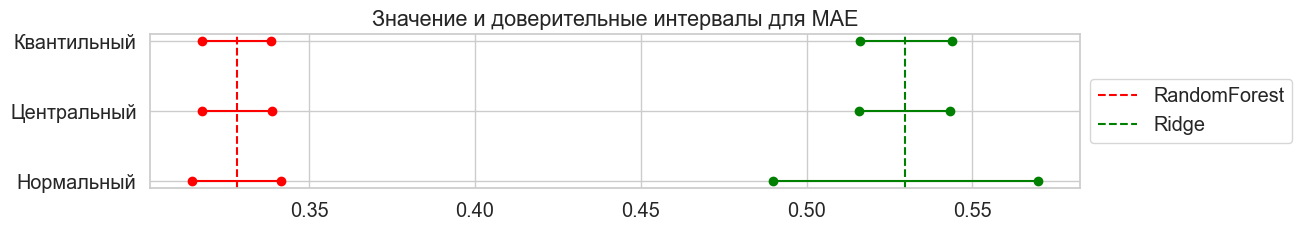

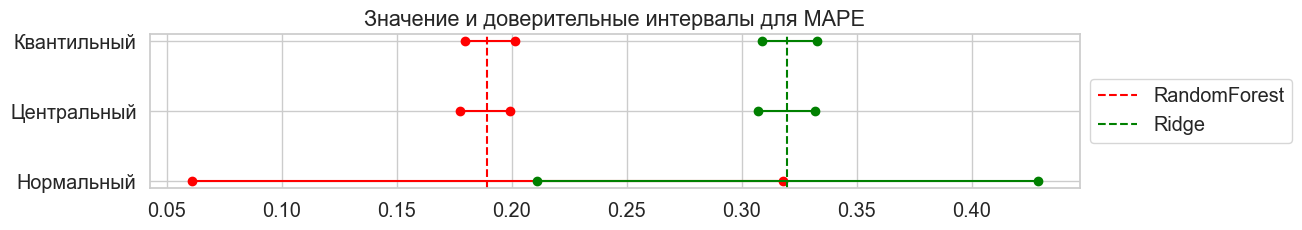

In [127]:
y_rf, y_ridge = [Model().fit(X_train,y_train).predict(X_test) for Model in [RandomForestRegressor, Ridge]]

for f, f_name in zip([lambda a,b: (a-b)**2, lambda a,b: np.abs(a-b), lambda a,b: np.abs((a-b)/a)], ['MSE','MAE','MAPE']):
    plt.figure(figsize=(12,2))
    # plt.xlabel('Интервал')
    plt.title(f'Значение и доверительные интервалы для {f_name}')
    for y_pred, model_name, color in zip([y_rf,y_ridge], ['RandomForest','Ridge'], ['red','green']):
        err = f(y_test, y_pred)
        plt.axvline(np.mean(err), linestyle='--', label=model_name, color=color)
        for interval, i_name in zip([ni,ci,qi], ['Нормальный','Центральный','Квантильный']):
            plt.plot(interval(err), [i_name,i_name], 'o-', color=color)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

***Вывод:** во-первых, получилось, что случайный лес обучился лучше (во всех случаях ошибка меньше). Во-вторых, все интервалы покрывают истинное значение ошибки, т.е. справляются с задачей. При этом, центральный и квантильный интервалы узкие и очень близки друг к другу, в то время как нормальный интервал заметно шире их обоих.*

___
### Задача 2.

**1.** Сгенерируйте выборку $X_1, ..., X_{10000}$ из стандартного нормального распределения. Для каждого $n \leqslant 10000$ постройте эмпирическую функцию распределения $\widehat{F}_n$ и посчитайте **точное** значение статистики 

$$D_n = \sup\limits_{x \in \mathbb{R}} \left| \widehat{F}_n(x) - F(x) \right|.$$

Обоснуйте, почему при вашей реализации подсчета статистики полученное значение будет **точным**.

Постройте график зависимости статистики $D_n$ от $n$. Верно ли, что $D_n \to 0$ и в каком смысле?


Для выполнения задания можно использовать `statsmodels.distributions.empirical_distribution.ECDF`.

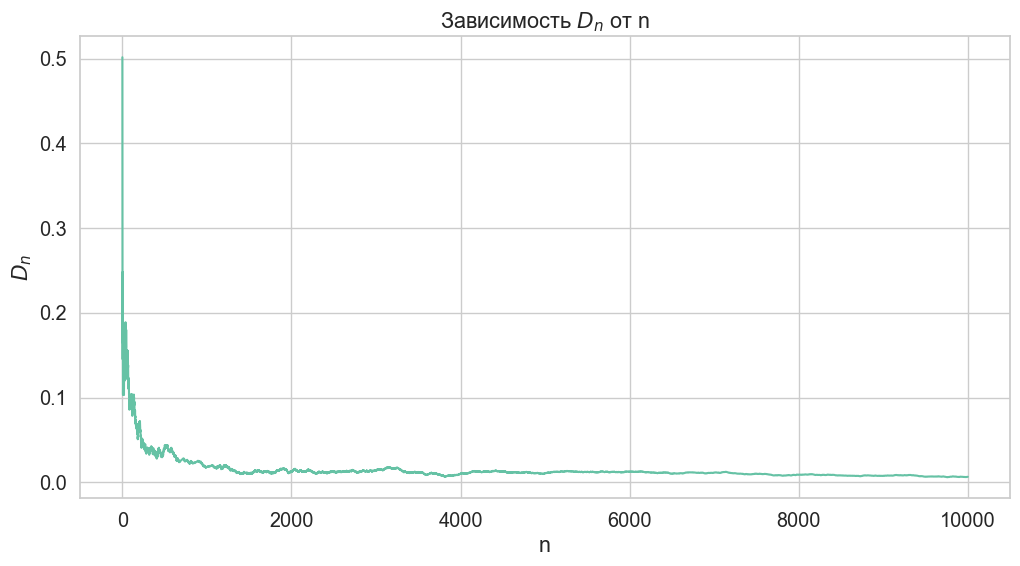

In [225]:
sample = sps.norm.rvs(size=10000)
F = np.array([sps.norm.cdf(x) for x in sample])
ns = np.arange(1, len(sample))
D_n = [np.abs(ECDF(sample[:n])(sample[:n]) - F[:n]).max() for n in ns]

plt.figure(figsize=(12,6))
plt.xlabel('n')
plt.ylabel('$D_n$')
plt.title(f'Зависимость $D_n$ от n')
plt.plot(ns, D_n)
plt.show()

***Вывод:***
1) *Значение $D_n$ получается точным, потому что эмпирическая функция распределения $\widehat{F}_n$ по данной выборке принимает ровно n ненулевых значений - по одному для каждого элемента выборки. При этом массив значений функции распределения $F(x)$, посчитанных в точках выборки, можно воспринимать как новую функцию, и тоже - с конечным набором значений. Поэтому для нахождения супремума достаточно перебрать n точек из выборки, а не всю действительную ось*  
2) *$D_n \to 0$ почти наверное, по теореме Гливенко-Кантелли. Это отражается на графике*  

---

### Задача 3.

В этой задаче вы исследуете различные непараметрические оценки распределений.
Для этого вам выдается почти готовый код функций `draw_ecdf`, `draw_hist` и `draw_pdf`, которые используются для построения ЭФР, гистограммы и ядерной оценки плотности соответственно. В реализациях этих функция часть кода пропущена, вам нужно его дописать. Код предполагает использование реализации ядерных оценок плотности из `statsmodels`.
При желании вы можете написать аналогичный код, используя реализацию в `seaborn`.

In [33]:
def draw_ecdf(sample, grid, cdf=None):
    """
    По сетке cтроит графики эмпирической функции распределения и истинной (если она задана) для всей выборки и для 1/10 ее части.
    Вход: sample: выборка, grid: сетка, cdf: истинная функция распределения из scipy.stats
    """
    plt.figure(figsize=(16, 3))
    for i, size in enumerate([len(sample) // 10, len(sample)]):  # выбирается размер выборки
        plt.subplot(1, 2, i + 1)
        plt.scatter(sample[:size], np.zeros(size), alpha=0.4, label='sample')  # точки выборки
        if cdf is not None:  # если передана истинная функция распределения, отрисовывается ее график
            plt.plot(grid, cdf(grid), color='green', alpha=0.3, lw=2, label='true cdf')
        # plt.plot(grid, <значения эфр (по первым size точек из sample) в точках grid>, color='red', label='ecdf')  # эфр
        plt.step(grid, np.searchsorted(np.sort(sample[:size]), grid, side='right') / size, color='red', label='ecdf')  # эфр
        plt.legend()
        plt.grid(ls=':')
        plt.title(f'sample size = {size}')
    plt.show()

def draw_hist(sample, grid, pdf=None):
    """
    Строит гистограмму и, по сетке, график истинной плотности (если она задана) для всей выборки и для 1/10 ее части.
    Вход: sample: выборка, grid: сетка, pdf: истинная плотность из scipy.stats
    """
    plt.figure(figsize=(16, 3))
    for i, size in enumerate([len(sample) // 10, len(sample)]):  # выбирается размер выборки
        plt.subplot(1, 2, i + 1)
        plt.hist(sample[:size], bins=20, range=(grid.min(),grid.max()), density=True, label='sample hist')  # гистограмма выборки
        if pdf is not None:  # если передана истинная плотность, отрисовывается ее график
            plt.plot(grid, pdf(grid), color='green', alpha=0.3, lw=2, label='true pdf')
        plt.legend()
    plt.show()

def draw_pdf(sample, grid, pdf=None):
    """
    По сетке cтроит графики ядерной оценки плотности и истинной плотности (если она задана) для всей выборки и для 1/10 ее части.
    Вход: sample: выборка, grid: сетка, pdf: истинная плотность из scipy.stats
    """
    plt.figure(figsize=(16, 3))
    for i, size in enumerate([len(sample) // 10, len(sample)]):  # выбирается размер выборки
        plt.subplot(1, 2, i + 1)
        plt.scatter(sample[:size], np.zeros(size), alpha=0.4, label='sample')  # точки выборки
        if pdf is not None:  # если передана истинная плотность, отрисовывается ее график
            plt.plot(grid, pdf(grid), color='green', alpha=0.3, lw=2, label='true pdf')
        kde = KDEUnivariate(sample[:size]).fit(bw='scott')
        plt.plot(grid, kde.evaluate(grid), color='red', label='kde')  # kde
        plt.legend()
        plt.grid(ls=':')
    plt.show()

Используя реализованные выше функции, постройте график эмпирической функции распределения (ЭФР), гистограмму и график ядерной оценки плотнотности к выборкам размера 500 для следующих распределений:

*1. Равномерное распределение $U[0,1]$*. Графики функции распределения и плотностей строить на интервале $(-0.2, 1.2)$.

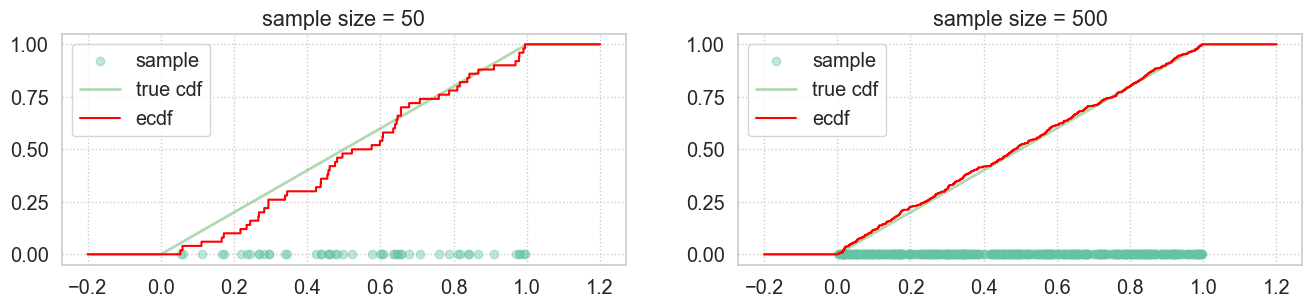

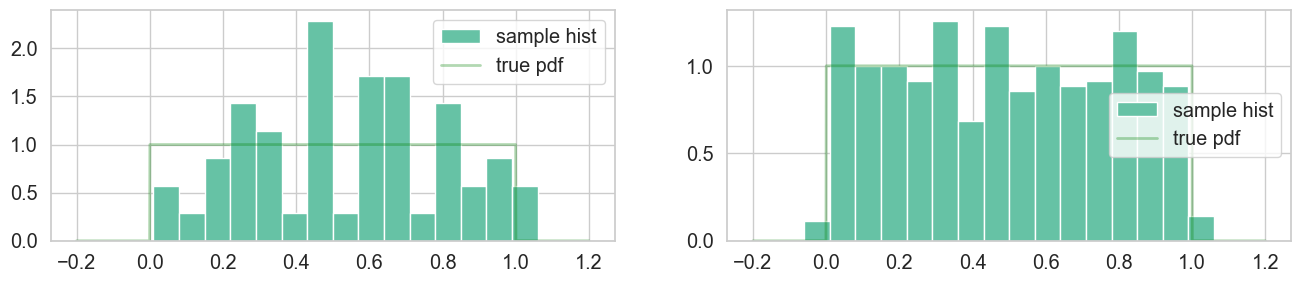

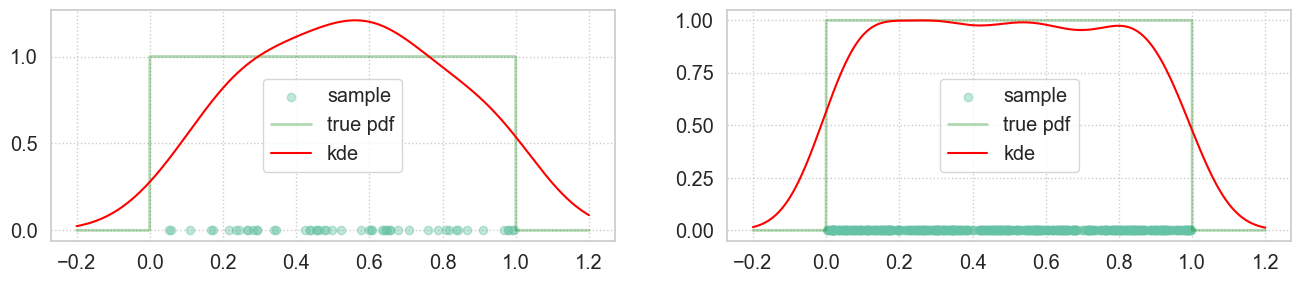

In [34]:
dist = sps.uniform(0,1)
sample, grid = dist.rvs(size=500), np.linspace(-0.2, 1.2, 2000)
draw_ecdf(sample, grid, dist.cdf)
draw_hist(sample, grid, dist.pdf)
draw_pdf(sample, grid, dist.pdf)

*2. Нормальное распределение $\mathcal{N}(0, 1)$.* Графики функции распределения и плотностей строить на интервале $(-3, 3)$.

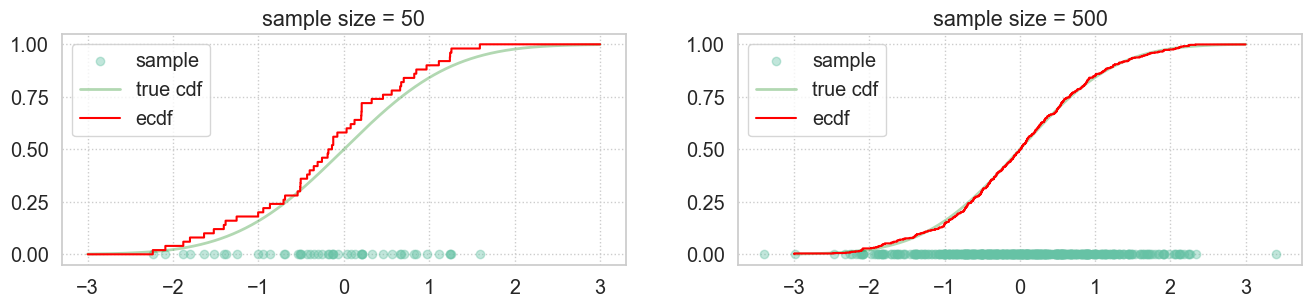

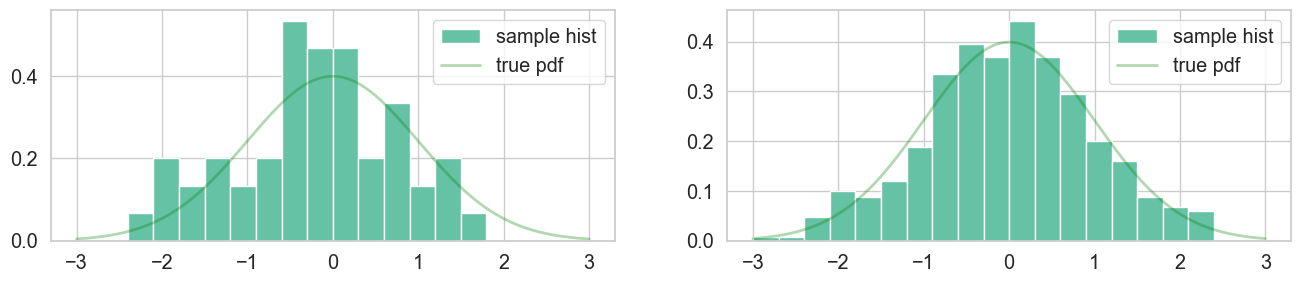

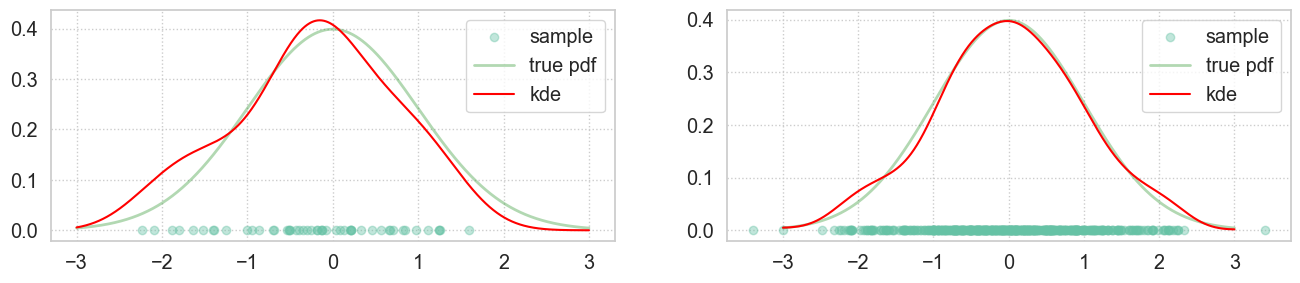

In [35]:
dist = sps.norm(0,1)
sample, grid = dist.rvs(size=500), np.linspace(-3, 3, 2000)
draw_ecdf(sample, grid, dist.cdf)
draw_hist(sample, grid, dist.pdf)
draw_pdf(sample, grid, dist.pdf)

*3. Экспоненциальное распределение $Exp(1)$.* Графики функции распределения и плотностей  строить на интервале $(-0.5, 5)$.

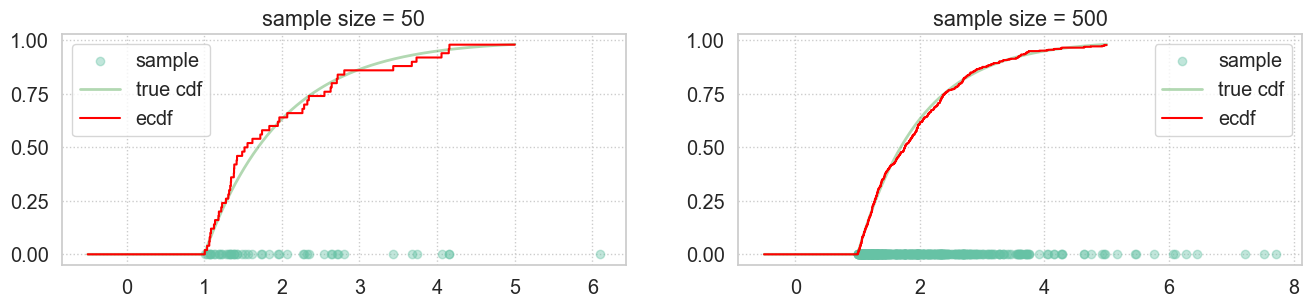

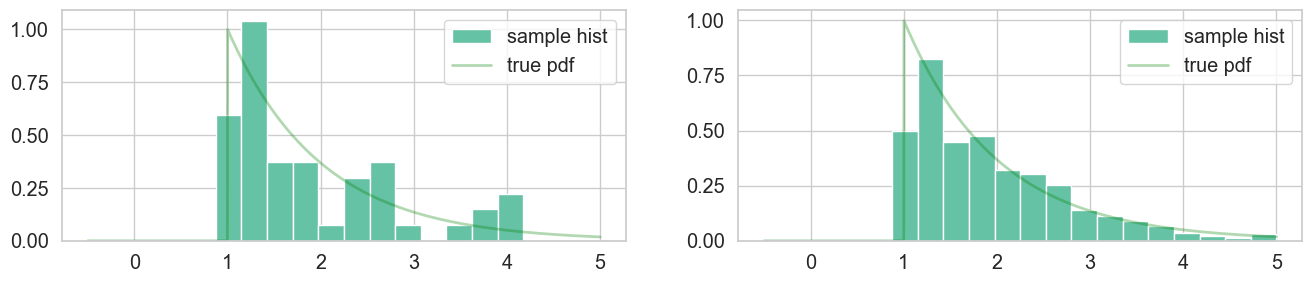

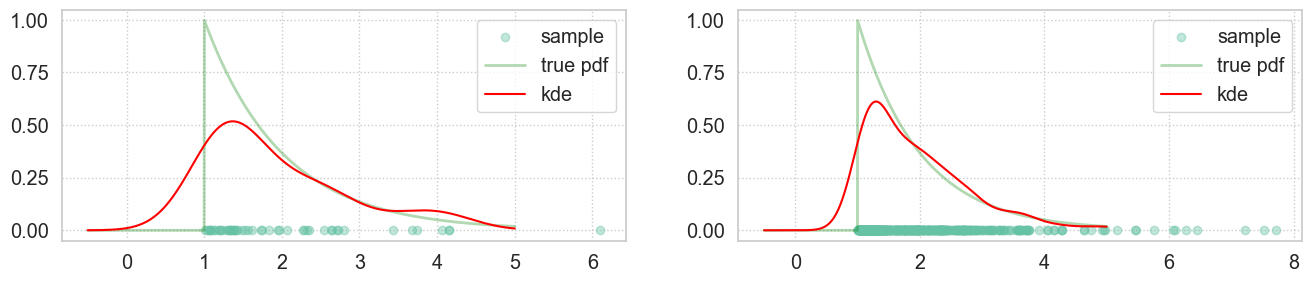

In [36]:
dist = sps.expon(1)
sample, grid = dist.rvs(size=500), np.linspace(-0.5, 5, 2000)
draw_ecdf(sample, grid, dist.cdf)
draw_hist(sample, grid, dist.pdf)
draw_pdf(sample, grid, dist.pdf)

Опишите полученные результаты, сравните их между выборками из различных распределений.

***Вывод:** по графикам видно, что ядерная оценка плотности - это сглаженная версия "эмпирической плотности" (понимаемой как обобщенная функция).*  
  
*Эмпирическая функция распределения, несмотря на свою дискретную природу ("ступенчатость"), неплохо аппроксимирует истинную функцию распределения во всех случаях (тем более - при большой выборке).*    
  
*Ядерная оценка плотности с ростом размера выборки приближается к реальной плотности, но лучше всего работает в случае нормального распределения. В силу сглаженности, ядерная оценка плотности плохо аппроксимирует плотность равномерного (где есть 4 прямых угла) и экспоненциального (где есть прямой угол и острый пик в 1). В то же время понятно, почему kde широко примененима на практике. Сглаживание позволяет учесть случайную природу наблюдений и перейти от дельта-функций в эмпирической плотности к чему-то более реалистичному и удобному (т.е. к функции, обладающей уже какой-то предсказательной способностью для свойств распределения). Это особенно полезно для обработки малых выборок.*  

---
### Задача 4.

Исследуйте вид ядерной оценки плотности в зависимости от вида ядра и его ширины.

Для этого сгенерируйте выборку $X_1, ..., X_{200}$ из распределения $U[0, 1]$ и постройте серию графиков для различной ширины гауссовского ядра, а затем другую серию графиков для различных типов ядер при фиксированной ширине. На каждом графике на отрезке $[-0.2, 1.2]$ должны быть изображены истинная плотность (полупрозрачным цветом) и ее ядерная оценка, а так же с нулевой $y$-координатой должны быть нанесены точки выборки. Для экономии места стройте графики в два столбца.

Вам выдется почти готовый код для выполнения задания с некоторыми пропусками. Код предполагает использование реализации ядерных оценок плотности из `statsmodels`. При желании вы можете написать аналогичный код, используя реализацию в `seaborn`. При построении KDE разрешается использовать цикл.

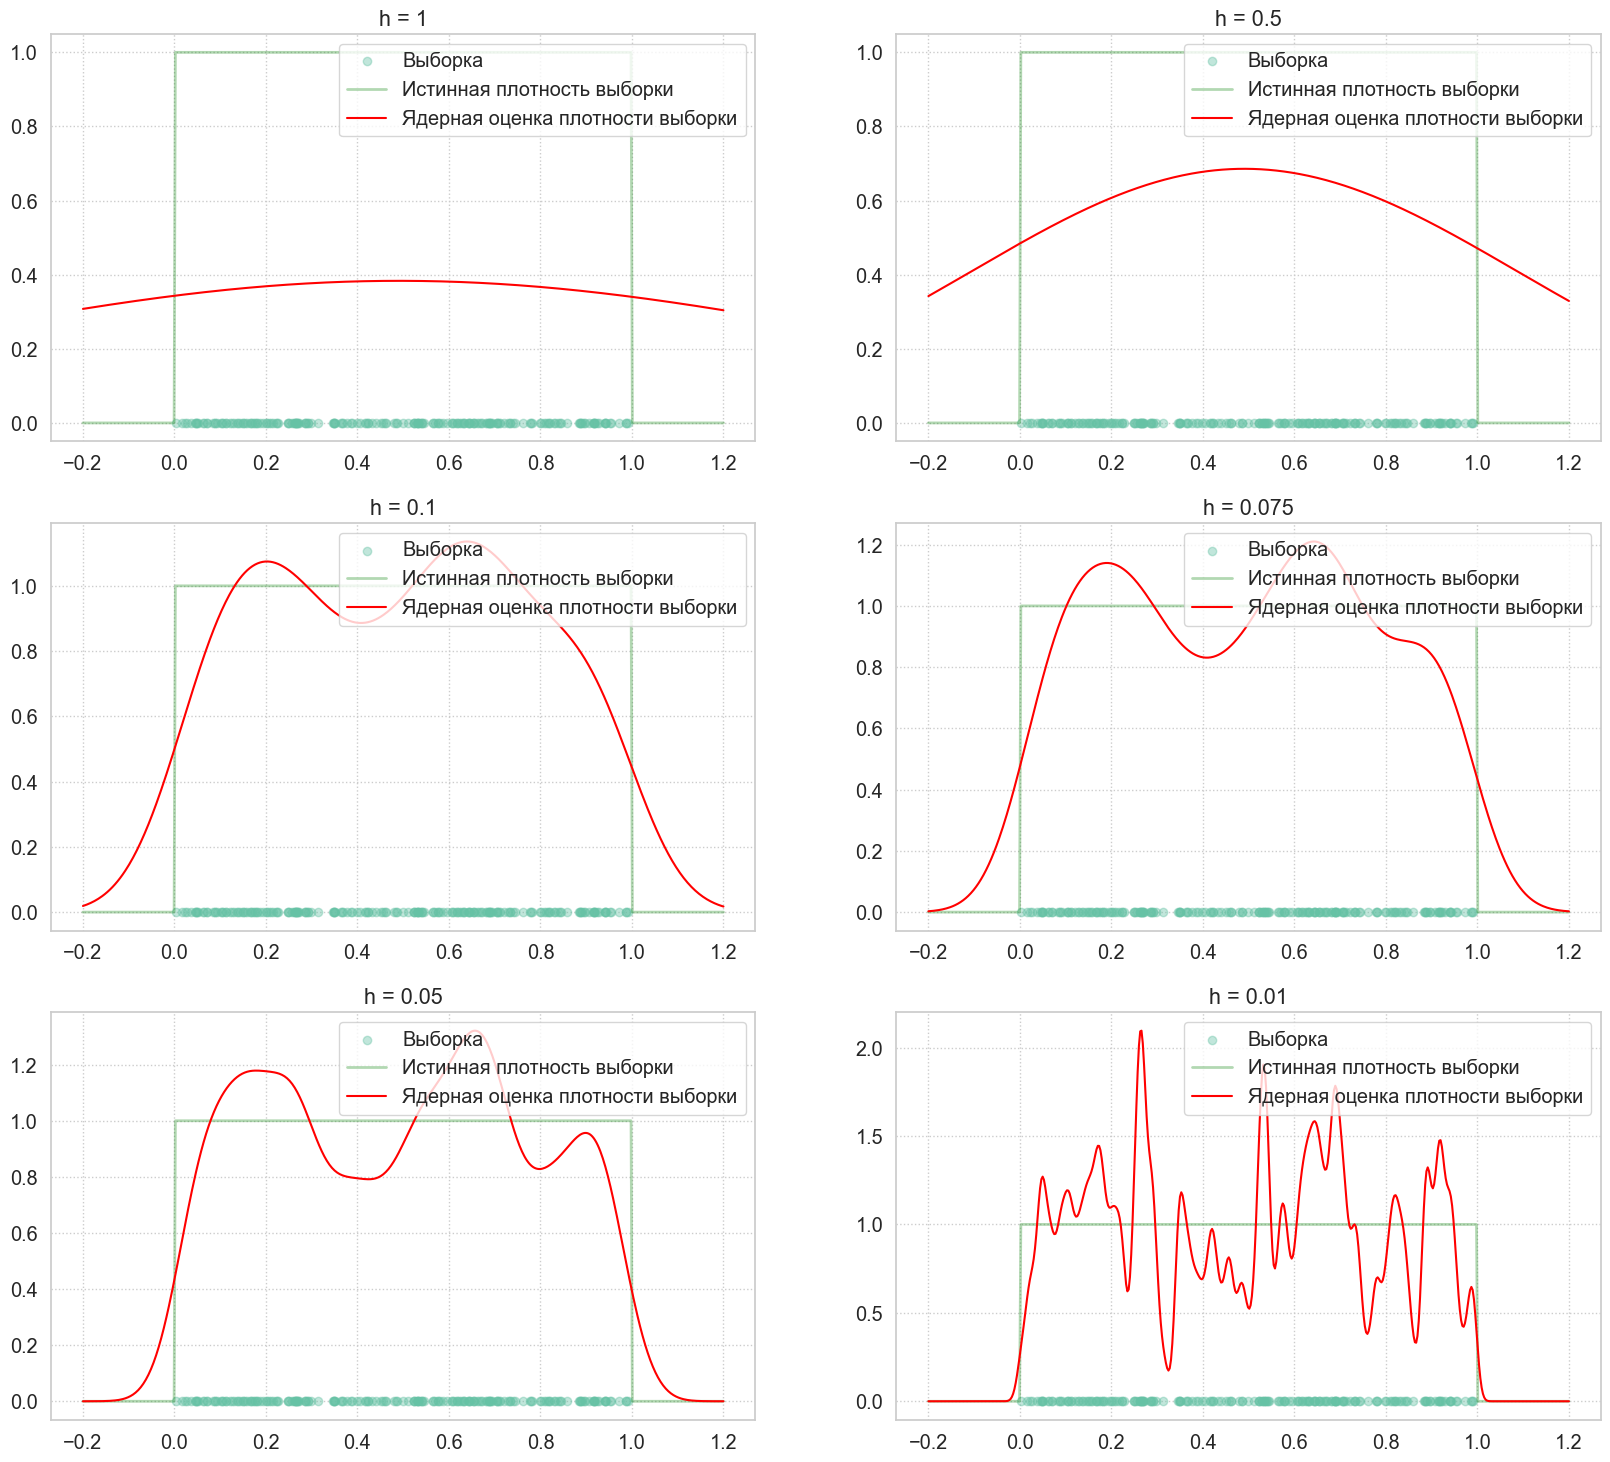

In [42]:
size = 200
sample = sps.uniform(0,1).rvs(size=size)  # выборка размера size
grid = np.linspace(-0.2, 1.2, 500)  # сетка на отрезке из условия
true_density = sps.uniform(0,1).pdf(grid)

plt.figure(figsize=(20, 18))
for i, bw in enumerate([1, 0.5, 0.1, 0.075, 0.05, 0.01]):  # итераций по ширине ядра
    plt.subplot(3, 2, i + 1)
    plt.scatter(sample, np.zeros(size), alpha=0.4, label='Выборка')
    plt.plot(grid, true_density, color='green', alpha=0.3, lw=2, label='Истинная плотность выборки')
    kernel_dens = KDEUnivariate(sample).fit(kernel='gau', bw=bw).evaluate(grid)  # kde
    plt.plot(grid, kernel_dens, color='red', label='Ядерная оценка плотности выборки')
    plt.legend(loc=1)
    plt.grid(ls=':')
    plt.title(f'h = {bw}')
plt.show()

*Видно, что размер ядра - это, по сути, сила сглаживания kde. При нулевой ширине ядра мы бы работали с суммой дельта-функций, т.е. с эмпирической плотностью. При бесконечной ширине ядра сглаживание чрезмерное и kde вырождается в константу. Оптимальное значение h лежит где-то посередине, и видимо, подбирается эвристически*

Во втором случае графики постройте аналогичным образом, проведя итерации по типу ядра.

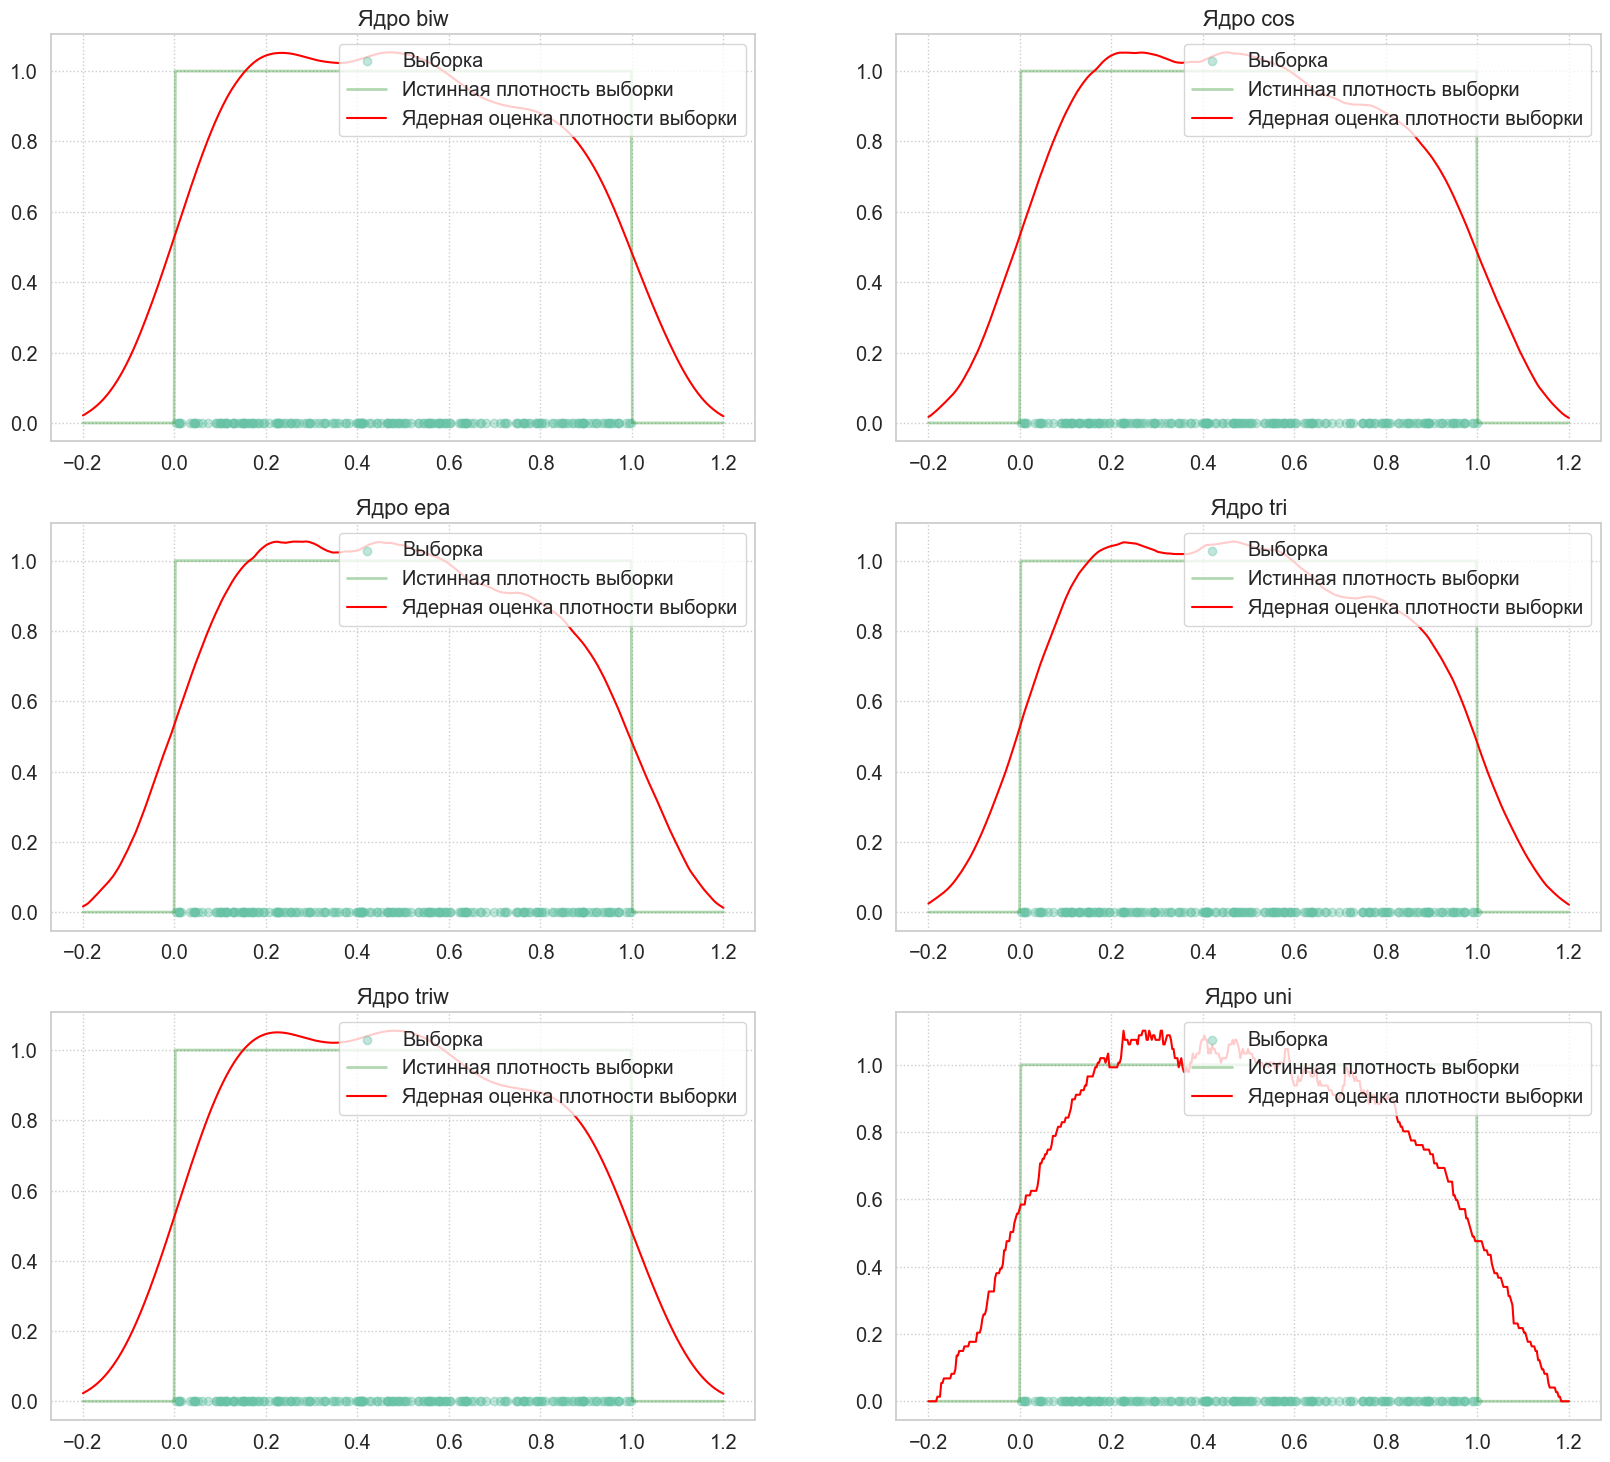

In [60]:
plt.figure(figsize=(20, 18))
for i, kernel in enumerate(['biw','cos','epa','tri','triw','uni']):  # итераций по типу ядра (без gau)
    plt.subplot(3, 2, i + 1)
    plt.scatter(sample, np.zeros(size), alpha=0.4, label='Выборка')
    plt.plot(grid, true_density, color='green', alpha=0.3, lw=2, label='Истинная плотность выборки')
    kde = KDEUnivariate(sample).fit(kernel=kernel, fft=False)  # kde
    kd_list = [kde.evaluate(g) for g in grid]  # пишут, баг в векторизации на стороне statsmodels
    kernel_dens = np.concatenate([np.array([0]) if k is np.nan else k for k in kd_list])
    plt.plot(grid, kernel_dens, color='red', label='Ядерная оценка плотности выборки')
    plt.legend(loc=1)
    plt.grid(ls=':')
    plt.title(f'Ядро {kernel}')
plt.show()

*Графики оказались очень похожими друг на друга (кроме, возможно, случая ядра uniform, имеющего ступенчатый вид). Тип ядра как раз отвечает за различия по форме, и тоже, видимо, подбирается эвристически*

***Вывод:*** 
  
*По первому подпункту (при переборе размеров гауссовых ядер) видно, что ширина ядра h - это, по сути, сила сглаживания kde. При нулевой ширине ядра мы бы работали с суммой дельта-функций, т.е. с эмпирической плотностью. При бесконечной ширине ядра сглаживание чрезмерное и kde вырождается в константу. Оптимальное значение h лежит где-то посередине, и видимо, подбирается эвристически*  
  
*По второму подпункту (при переборе типов ядер) видно, что графики оказались очень похожими друг на друга (кроме, возможно, случая ядра uniform, имеющего ступенчатый вид). Тип ядра как раз отвечает за различия по форме, и тоже, видимо, подбирается эвристически*

---
### Задача 5.  (в чате написали, что задача перешла в следующее дз)

Рассмотрим задачу регрессии. Мы уже научились оценивать зависимость $y(x)$, но это только точечная оценка для каждого конкретного $x$. На практике бывает необходимо строить доверительные интервалы, которые в совокупности образуют доверительные ленты. Поскольку мы ничего не знаем про распределение ошибок, будем строить доверительную ленту по методу бутстрепа.

1. Сгенерируем достаточно большое число бутстрепных выборок.

2. Обучим модели и получим значения $\widehat{y}(x)$, для всех значений $x$ по сетке значений.

3. По предсказаным значениям оценим верхнюю и нижнюю границы ленты с помощью методов построения бутстрепных доверительных интервалов.

Напишите функцию, которая реализует данный метод

In [206]:
def bootstrap_confidence_interval(X, Y, Model, X_grid=None, bootstrap_count=None, alpha=0.95, model_args={}):
    '''
    Построение предсказательной ленты для модели регрессии.
    X,Y - выборка, Model - класс модели, X_grid - сетка для доверительной ленты, alpha - уровень доверия,
    bootstrap_count - количество бутстрепных выборок, model_args - параметры модели.
    '''
    X, Y, X_grid = X.to_numpy(), Y.to_numpy(), X_grid.reshape(-1, 1)
    n = len(Y)
    if bootstrap_count is None:
        bootstrap_count = len(X_grid)
    predictions = []
    for _ in tqdm(np.arange(bootstrap_count)):
        bootstrap_model = Model(**model_args)
        indices = sps.randint.rvs(0, n, size=n)
        bootstrap_model.fit(np.take(X, indices).reshape(-1, 1), np.take(Y, indices).reshape(-1, 1))
        predictions.append(bootstrap_model.predict(X_grid))
    ribbon = np.array([ni(pred, alpha) for pred in predictions])  # готовый метод из задачи 1
    return ribbon[:,0], ribbon[:,1]  # lower, upper

def draw(X_test, y_test, X_grid, lb, ub):
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test, y_test, color='blue', label='Выборка (test)')
    plt.fill_between(X_grid, lb, ub, color='green', alpha=0.4, label='Нормальный интервал')
    # plt.xlim(-7, 7)
    # plt.ylim(-0.01, 0.3)
    plt.xlabel('X (age)')
    plt.ylabel('Y (logwage)')
    plt.title('Доверительная лента')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

Рассмотрим датасет cps71 из семинара

In [205]:
data = pd.read_csv('cps71.csv', index_col=0)
X, Y = data['age'], data['logwage']
data.head(3)

,logwage,age
1,11.1563,21
2,12.8131,22
3,13.0960,22


Разделим нашу выборку на обучающую и тестовую

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
X_grid = np.linspace(X_test.min(), X_test.max(), 5)

Постройте доверительные ленты для моделей линейной регрессии, ядерной регрессии и KNN-регрессии.
Изобразите на графике также предсказания каждой модели и обучающую выборку.

*Примечание: для классов из statmodels сигнатура класса может не совпадать со стандартной, поэтому сделайте для этих классов, класс-обертку, который в себе просто будет вызывать нужные методы.*

In [208]:
class KernelRegression():  # обертка
    def __init__(self, *args, **kwargs):
        self.args, self.kwargs = args, kwargs
    def fit(self, X, Y):
        self.reg = KernelReg(Y, X, *self.args, var_type='o', **self.kwargs)
        return self
    def predict(self, X):
        return self.reg.fit()[0]

  0%|          | 0/5 [00:00<?, ?it/s]

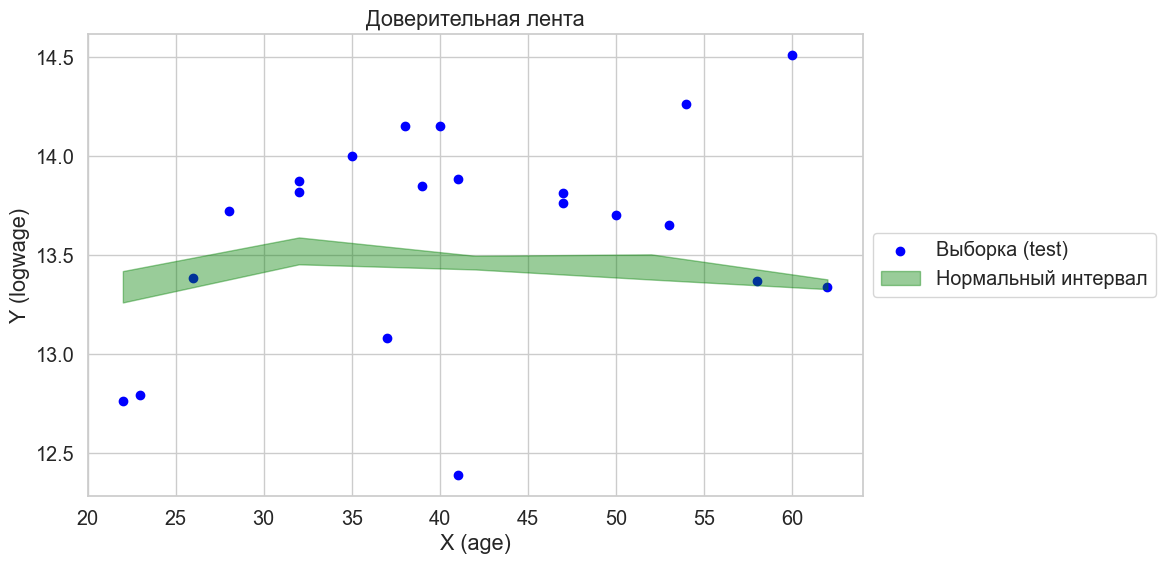

In [223]:
lb,ub = bootstrap_confidence_interval(X_train, y_train, KernelRegression, X_grid, alpha=0.95, model_args={})
draw(X_test, y_test, X_grid, lb, ub)

  0%|          | 0/5 [00:00<?, ?it/s]

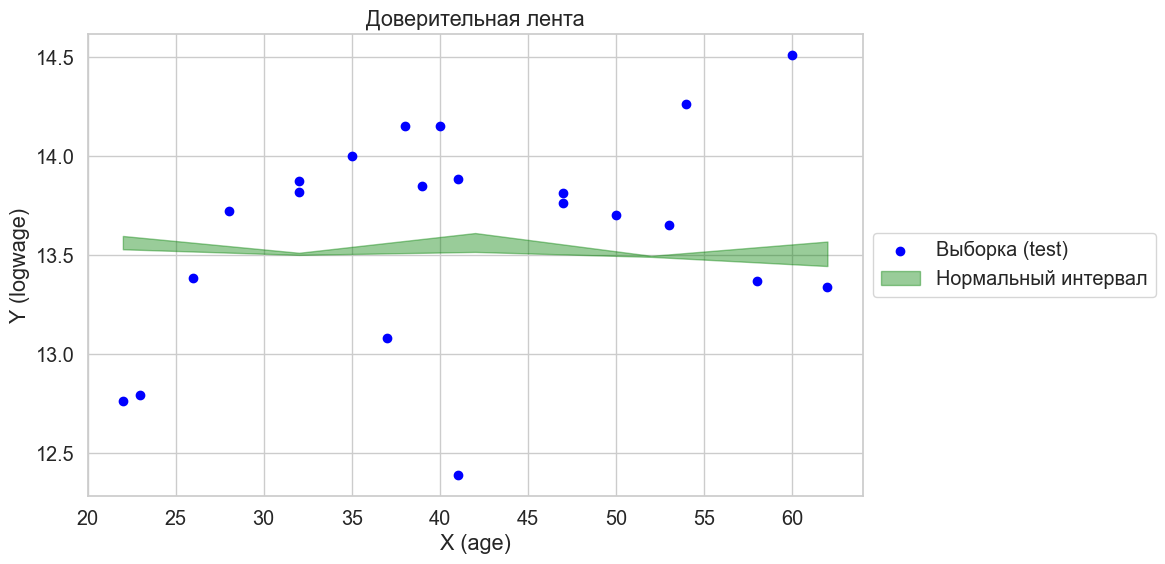

In [221]:
lb,ub = bootstrap_confidence_interval(X_train, y_train, LinearRegression, X_grid, alpha=0.95, model_args={})
draw(X_test, y_test, X_grid, lb, ub)

  0%|          | 0/5 [00:00<?, ?it/s]

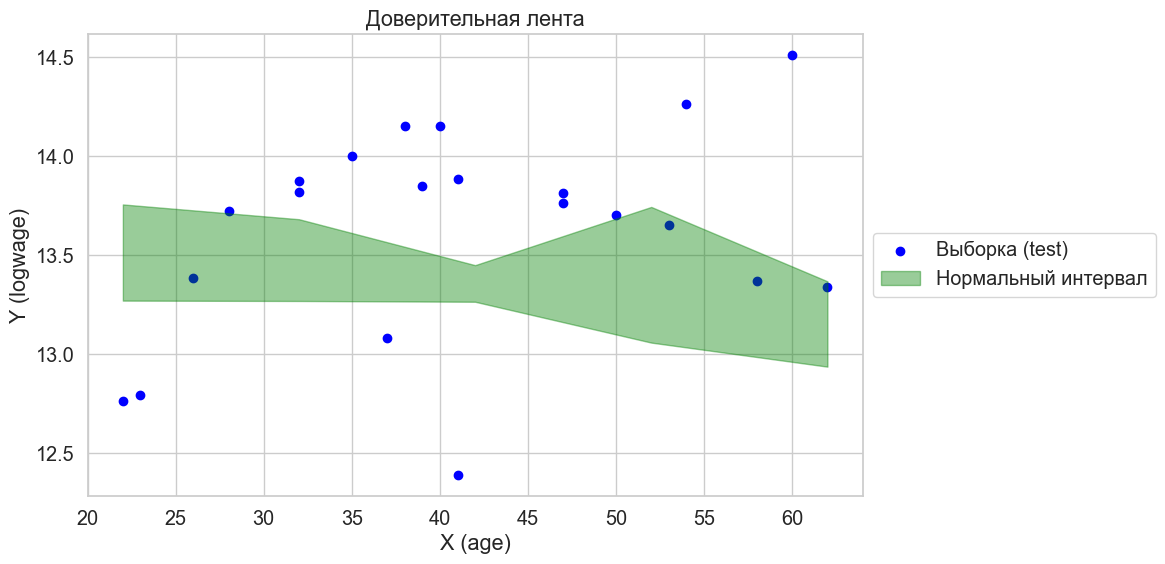

In [222]:
lb,ub = bootstrap_confidence_interval(X_train, y_train, KNeighborsRegressor, X_grid, alpha=0.95, model_args={})
draw(X_test, y_test, X_grid, lb, ub)

Сделайте выводы

**Вывод:**

<...>